In [467]:
"""CorEx Hierarchical Topic Models
Use the principle of Total Cor-relation Explanation (CorEx) to construct
hierarchical topic models. This module is specially designed for sparse count
data and implements semi-supervision via the information bottleneck.
Greg Ver Steeg and Aram Galstyan. "Maximally Informative Hierarchical
Representations of High-Dimensional Data." AISTATS, 2015.
Gallagher et al. "Anchored Correlation Explanation: Topic Modeling with Minimal
Domain Knowledge." TACL, 2017.
Code below written by:
Greg Ver Steeg (gregv@isi.edu)
Ryan J. Gallagher
David Kale
Lily Fierro
License: Apache V2
"""

import numpy as np  # Tested with 1.8.0
from os import makedirs
from os import path
from scipy.special import logsumexp # Tested with 0.13.0
import scipy.sparse as ss
from six import string_types # For Python 2&3 compatible string checking
from sklearn.externals import joblib


class Corex(object):
    """
    Anchored CorEx hierarchical topic models
    Code follows sklearn naming/style (e.g. fit(X) to train)
    Parameters
    ----------
    n_hidden : int, optional, default=2
        Number of hidden units.
    max_iter : int, optional
        Maximum number of iterations before ending.
    verbose : int, optional
        The verbosity level. The default, zero, means silent mode. 1 outputs TC(X;Y) as you go
        2 output alpha matrix and MIs as you go.
    tree : bool, default=True
        In a tree model, each word can only appear in one topic. tree=False is not yet implemented.
    count : string, {'binarize', 'fraction'}
        Whether to treat counts (>1) by directly binarizing them, or by constructing a fractional count in [0,1].
    seed : integer or numpy.RandomState, optional
        A random number generator instance to define the state of the
        random permutations generator. If an integer is given, it fixes the
        seed. Defaults to the global numpy random number generator.
    Attributes
    ----------
    labels : array, [n_samples, n_hidden]
        Label for each hidden unit for each sample.
    clusters : array, [n_visible]
        Cluster label for each input variable.
    p_y_given_x : array, [n_samples, n_hidden]
        p(y_j=1|x) for each sample.
    alpha : array-like, shape [n_hidden, n_visible]
        Adjacency matrix between input variables and hidden units. In range [0,1].
    mis : array, [n_hidden, n_visible]
        Mutual information between each (visible/observed) variable and hidden unit
    tcs : array, [n_hidden]
        TC(X_Gj;Y_j) for each hidden unit
    tc : float
        Convenience variable = Sum_j tcs[j]
    tc_history : array
        Shows value of TC over the course of learning. Hopefully, it is converging.
    words : list of strings
        Feature names that label the corresponding columns of X
    References
    ----------
    [1]     Greg Ver Steeg and Aram Galstyan. "Discovering Structure in
            High-Dimensional Data Through Correlation Explanation."
            NIPS, 2014. arXiv preprint arXiv:1406.1222.
    [2]     Greg Ver Steeg and Aram Galstyan. "Maximally Informative
            Hierarchical Representations of High-Dimensional Data"
            AISTATS, 2015. arXiv preprint arXiv:1410.7404.
    """

    def __init__(self, n_hidden=2, max_iter=200, eps=1e-5, seed=None, verbose=False, count='binarize',
                 tree=True, **kwargs):
        self.n_hidden = n_hidden  # Number of hidden factors to use (Y_1,...Y_m) in paper
        self.max_iter = max_iter  # Maximum number of updates to run, regardless of convergence
        self.eps = eps  # Change to signal convergence
        self.tree = tree
        np.random.seed(seed)  # Set seed for deterministic results
        self.verbose = verbose
        self.t = 20  # Initial softness of the soft-max function for alpha (see NIPS paper [1])
        self.count = count  # Which strategy, if necessary, for binarizing count data
        if verbose > 0:
            np.set_printoptions(precision=3, suppress=True, linewidth=200)
            print('corex, rep size:', n_hidden)
        if verbose:
            np.seterr(all='warn')
            # Can change to 'raise' if you are worried to see where the errors are
            # Locally, I "ignore" underflow errors in logsumexp that appear innocuous (probabilities near 0)
        else:
            np.seterr(all='ignore')

    def label(self, p_y_given_x):
        """Maximum likelihood labels for some distribution over y's"""
        return (p_y_given_x > 0.5).astype(bool)

    @property
    def labels(self):
        """Maximum likelihood labels for training data. Can access with self.labels (no parens needed)"""
        return self.label(self.p_y_given_x)

    @property
    def clusters(self):
        """Return cluster labels for variables"""
        return np.argmax(self.alpha, axis=0)

    @property
    def sign(self):
        """Return the direction of correlation, positive or negative, for each variable-latent factor."""
        return np.sign(self.theta[3] - self.theta[2]).T

    @property
    def tc(self):
        """The total correlation explained by all the Y's.
        """
        return np.sum(self.tcs)

    def fit(self, X, anchors=None, anchor_strength=1, words=None, docs=None):
        """
        Fit CorEx on the data X. See fit_transform.
        """
        self.fit_transform(X, anchors=anchors, anchor_strength=anchor_strength, words=words, docs=docs)
        return self

    def fit_transform(self, X, anchors=None, anchor_strength=1, words=None, docs=None):
        """Fit CorEx on the data
        Parameters
        ----------
        X : scipy sparse CSR or a numpy matrix, shape = [n_samples, n_visible]
            Count data or some other sparse binary data.
        anchors : A list of variables anchor each corresponding latent factor to.
        anchor_strength : How strongly to weight the anchors.
        words : list of strings that label the corresponding columns of X
        docs : list of strings that label the corresponding rows of X
        Returns
        -------
        Y: array-like, shape = [n_samples, n_hidden]
           Learned values for each latent factor for each sample.
           Y's are sorted so that Y_1 explains most correlation, etc.
        """
        X = self.preprocess(X)
        self.initialize_parameters(X, words, docs)
        if anchors is not None:
            anchors = self.preprocess_anchors(list(anchors))
        p_y_given_x = np.random.random((self.n_samples, self.n_hidden))
        if anchors is not None:
            for j, a in enumerate(anchors):
                p_y_given_x[:, j] = 0.5 * p_y_given_x[:, j] + 0.5 * X[:, a].mean(axis=1).A1  # Assumes X is a binary matrix

        for nloop in range(self.max_iter):
            if nloop > 1:
                for j in range(self.n_hidden):
                    if self.sign[j, np.argmax(self.mis[j])] < 0:
                        # Switch label for Y_j so that it is correlated with the top word
                        p_y_given_x[:, j] = 1. - p_y_given_x[:, j]
            self.log_p_y = self.calculate_p_y(p_y_given_x)
            self.theta = self.calculate_theta(X, p_y_given_x, self.log_p_y)  # log p(x_i=1|y)  nv by m by k

            if nloop > 0:  # Structure learning step
                self.alpha = self.calculate_alpha(X, p_y_given_x, self.theta, self.log_p_y, self.tcs)
            if anchors is not None:
                for a in flatten(anchors):
                    self.alpha[:, a] = 0
                for ia, a in enumerate(anchors):
                    self.alpha[ia, a] = anchor_strength

            p_y_given_x, _, log_z = self.calculate_latent(X, self.theta)

            self.update_tc(log_z)  # Calculate TC and record history to check convergence
            self.print_verbose()
            if self.convergence():
                break

        if self.verbose:
            print('Overall tc:', self.tc)

        if anchors is None:
            self.sort_and_output(X)
        self.p_y_given_x, self.log_p_y_given_x, self.log_z = self.calculate_latent(X, self.theta)  # Needed to output labels
        self.mis = self.calculate_mis(self.theta, self.log_p_y)  # / self.h_x  # could normalize MIs
        return self.labels

    def transform(self, X, details=False):
        """
        Label hidden factors for (possibly previously unseen) samples of data.
        Parameters: samples of data, X, shape = [n_samples, n_visible]
        Returns: , shape = [n_samples, n_hidden]
        """
        X = self.preprocess(X)
        p_y_given_x, _, log_z = self.calculate_latent(X, self.theta)
        labels = self.label(p_y_given_x)
        if details == 'surprise':
            # TODO: update
            # Totally experimental
            n_samples = X.shape[0]
            alpha = np.zeros((self.n_hidden, self.n_visible))
            for i in range(self.n_visible):
                alpha[np.argmax(self.alpha[:, i]), i] = 1
            log_p = np.empty((2, n_samples, self.n_hidden))
            c0 = np.einsum('ji,ij->j', alpha, self.theta[0])
            c1 = np.einsum('ji,ij->j', alpha, self.theta[1])  # length n_hidden
            info0 = np.einsum('ji,ij->ij', alpha, self.theta[2] - self.theta[0])
            info1 = np.einsum('ji,ij->ij', alpha, self.theta[3] - self.theta[1])
            log_p[1] = c1 + X.dot(info1)  # sum_i log p(xi=xi^l|y_j=1)  # Shape is 2 by l by j
            log_p[0] = c0 + X.dot(info0)  # sum_i log p(xi=xi^l|y_j=0)
            surprise = [-np.sum([log_p[labels[l, j], l, j] for j in range(self.n_hidden)]) for l in range(n_samples)]
            return p_y_given_x, log_z, np.array(surprise)
        elif details:
            return p_y_given_x, log_z
        else:
            return labels

    def predict_proba(self, X):
        return self.transform(X, details=True)

    def predict(self, X):
        return self.transform(X, details=False)

    def preprocess(self, X):
        """Data can be binary or can be in the range [0,1], where that is interpreted as the probability to
        see this variable in a given sample"""
        if X.max() > 1:
            if self.count == 'binarize':
                X = (X > 0)
            elif self.count == 'fraction':
                X = X.astype(float)
                count = np.array(X.sum(axis=0), dtype=float).ravel()
                length = np.array(X.sum(axis=1)).ravel().clip(1)
                bg_rate = ss.diags(float(X.sum()) / count, 0)
                doc_length = ss.diags(1. / length, 0)
                # max_counts = ss.diags(1. / X.max(axis=1).A.ravel(), 0)
                X = doc_length * X * bg_rate
                X.data = np.clip(X.data, 0, 1)  # np.log(X.data) / (np.log(X.data) + 1)
        return X

    def initialize_parameters(self, X, words, docs):
        """Store some statistics about X for future use, and initialize alpha, tc"""
        self.n_samples, self.n_visible = X.shape
        if self.n_hidden > 1:
            self.alpha = np.random.random((self.n_hidden, self.n_visible))
            # self.alpha /= np.sum(self.alpha, axis=0, keepdims=True)
        else:
            self.alpha = np.ones((self.n_hidden, self.n_visible), dtype=float)
        self.tc_history = []
        self.tcs = np.zeros(self.n_hidden)
        self.word_counts = np.array(
            X.sum(axis=0)).ravel()  # 1-d array of total word occurrences. (Probably slow for CSR)
        if np.any(self.word_counts == 0) or np.any(self.word_counts == self.n_samples):
            print('WARNING: Some words never appear (or always appear)')
            self.word_counts = self.word_counts.clip(0.01, self.n_samples - 0.01)
        self.word_freq = (self.word_counts).astype(float) / self.n_samples
        self.px_frac = (np.log1p(-self.word_freq) - np.log(self.word_freq)).reshape((-1, 1))  # nv by 1
        self.lp0 = np.log1p(-self.word_freq).reshape((-1, 1))  # log p(x_i=0)
        self.h_x = binary_entropy(self.word_freq)
        if self.verbose:
            print('word counts', self.word_counts)
        # Set column labels
        self.words = words
        if words is not None:
            if len(words) != X.shape[1]:
                print('WARNING: number of column labels != number of columns of X. Check len(words) and X.shape[1]')
            col_index2word = {index:word for index,word in enumerate(words)}
            word2col_index = {word:index for index,word in enumerate(words)}
            self.col_index2word = col_index2word
            self.word2col_index = word2col_index
        else:
            self.col_index2word = None
            self.word2col_index = None
        # Set row labels
        self.docs = docs
        if docs is not None:
            if len(docs) != X.shape[0]:
                print('WARNING: number of row labels != number of rows of X. Check len(docs) and X.shape[0]')
            row_index2doc = {index:doc for index,doc in enumerate(docs)}
            self.row_index2doc = row_index2doc
        else:
            self.row_index2doc = None

    def update_word_parameters(self, X, words):
        """
        updates parameters that need to be changed for each new model update
        specifically, this re-calculates word count related parameters to be based on X,
        where X is a batch of new data
        """
        self.n_samples, self.n_visible = X.shape
        self.word_counts = np.array(
            X.sum(axis=0)).ravel()  # 1-d array of total word occurrences. (Probably slow for CSR)
        if np.any(self.word_counts == 0) or np.any(self.word_counts == self.n_samples):
            print('WARNING: Some words never appear (or always appear)')
            self.word_counts = self.word_counts.clip(0.01, self.n_samples - 0.01)
        self.word_freq = (self.word_counts).astype(float) / self.n_samples
        self.px_frac = (np.log1p(-self.word_freq) - np.log(self.word_freq)).reshape((-1, 1))  # nv by 1
        self.lp0 = np.log1p(-self.word_freq).reshape((-1, 1))  # log p(x_i=0)
        self.h_x = binary_entropy(self.word_freq)
        if self.verbose:
            print('word counts', self.word_counts)
        self.words = words
        if words is not None:
            if len(words) != X.shape[1]:
                print('WARNING: number of column labels != number of columns of X. Check len(words) and X.shape[1]')
            col_index2word = {index:word for index,word in enumerate(words)}
            word2col_index = {word:index for index,word in enumerate(words)}
            self.col_index2word = col_index2word
            self.word2col_index = word2col_index
        else:
            self.col_index2word = None
            self.word2col_index = None

    def preprocess_anchors(self, anchors):
        """Preprocess anchors so that it is a list of column indices if not already"""
        if anchors is not None:
            for n, anchor_list in enumerate(anchors):
                # Check if list of anchors or a single str or int anchor
                if type(anchor_list) is not list:
                    anchor_list = [anchor_list]
                # Convert list of anchors to list of anchor indices
                new_anchor_list = []
                for anchor in anchor_list:
                    # Turn string anchors into index anchors
                    if isinstance(anchor, string_types):
                        if self.words is not None:
                            if anchor in self.word2col_index:
                                new_anchor_list.append(self.word2col_index[anchor])
                            else:
                                raise KeyError('Anchor word not in word column labels provided to CorEx: {}'.format(anchor))
                        else:
                                raise NameError("Provided non-index anchors to CorEx without also providing 'words'")
                    else:
                        new_anchor_list.append(anchor)
                # Update anchors with new anchor list
                if len(new_anchor_list) == 1:
                    anchors[n] = new_anchor_list[0]
                else:
                    anchors[n] = new_anchor_list

        return anchors

    def calculate_p_y(self, p_y_given_x):
        """Estimate log p(y_j=1)."""
        return np.log(np.mean(p_y_given_x, axis=0))  # n_hidden, log p(y_j=1)

    def calculate_theta(self, X, p_y_given_x, log_p_y):
        """Estimate marginal parameters from data and expected latent labels."""
        # log p(x_i=1|y)
        n_samples = X.shape[0]
        p_dot_y = X.T.dot(p_y_given_x).clip(0.01 * np.exp(log_p_y), (n_samples - 0.01) * np.exp(
            log_p_y))  # nv by ns dot ns by m -> nv by m  # TODO: Change to CSC for speed?
        lp_1g1 = np.log(p_dot_y) - np.log(n_samples) - log_p_y
        lp_1g0 = np.log(self.word_counts[:, np.newaxis] - p_dot_y) - np.log(n_samples) - log_1mp(log_p_y)
        lp_0g0 = log_1mp(lp_1g0)
        lp_0g1 = log_1mp(lp_1g1)
        return np.array([lp_0g0, lp_0g1, lp_1g0, lp_1g1])  # 4 by nv by m

    def calculate_alpha(self, X, p_y_given_x, theta, log_p_y, tcs):
        """A rule for non-tree CorEx structure."""
        # TODO: Could make it sparse also? Well, maybe not... at the beginning it's quite non-sparse
        mis = self.calculate_mis(theta, log_p_y)
        if self.n_hidden == 1:
            alphaopt = np.ones((1, self.n_visible))
        elif self.tree:
            # sa = np.sum(self.alpha, axis=0)
            tc_oom = 1. / self.n_samples
            sa = np.sum(self.alpha[tcs > tc_oom], axis=0)
            self.t = np.where(sa > 1.1, 1.3 * self.t, self.t)
            # tc_oom = np.median(self.h_x)  # \propto TC of a small group of corr. variables w/median entropy...
            # t = 20 + (20 * np.abs(tcs) / tc_oom).reshape((self.n_hidden, 1))  # worked well in many tests
            t = (1 + self.t * np.abs(tcs).reshape((self.n_hidden, 1)))
            maxmis = np.max(mis, axis=0)
            for i in np.where((mis == maxmis).sum(axis=0))[0]:  # Break ties for the largest MI
                mis[:, i] += 1e-10 * np.random.random(self.n_hidden)
                maxmis[i] = np.max(mis[:, i])
            with np.errstate(under='ignore'):
                alphaopt = np.exp(t * (mis - maxmis) / self.h_x)
        else:
            # TODO: Can we make a fast non-tree version of update in the AISTATS paper?
            alphaopt = np.zeros((self.n_hidden, self.n_visible))
            top_ys = np.argsort(-mis, axis=0)[:self.tree]
            raise NotImplementedError
        self.mis = mis  # So we don't have to recalculate it when used later
        return alphaopt

    def calculate_latent(self, X, theta):
        """"Calculate the probability distribution for hidden factors for each sample."""
        ns, nv = X.shape
        log_pygx_unnorm = np.empty((2, ns, self.n_hidden))
        c0 = np.einsum('ji,ij->j', self.alpha, theta[0] - self.lp0)
        c1 = np.einsum('ji,ij->j', self.alpha, theta[1] - self.lp0)  # length n_hidden
        info0 = np.einsum('ji,ij->ij', self.alpha, theta[2] - theta[0] + self.px_frac)
        info1 = np.einsum('ji,ij->ij', self.alpha, theta[3] - theta[1] + self.px_frac)
        log_pygx_unnorm[1] = self.log_p_y + c1 + X.dot(info1)
        log_pygx_unnorm[0] = log_1mp(self.log_p_y) + c0 + X.dot(info0)
        return self.normalize_latent(log_pygx_unnorm)

    def normalize_latent(self, log_pygx_unnorm):
        """Normalize the latent variable distribution
        For each sample in the training set, we estimate a probability distribution
        over y_j, each hidden factor. Here we normalize it. (Eq. 7 in paper.)
        This normalization factor is used for estimating TC.
        Parameters
        ----------
        Unnormalized distribution of hidden factors for each training sample.
        Returns
        -------
        p_y_given_x : 3D array, shape (n_hidden, n_samples)
            p(y_j|x^l), the probability distribution over all hidden factors,
            for data samples l = 1...n_samples
        log_z : 2D array, shape (n_hidden, n_samples)
            Point-wise estimate of total correlation explained by each Y_j for each sample,
            used to estimate overall total correlation.
        """
        with np.errstate(under='ignore'):
            log_z = logsumexp(log_pygx_unnorm, axis=0)  # Essential to maintain precision.
            log_pygx = log_pygx_unnorm[1] - log_z
            p_norm = np.exp(log_pygx)
        return p_norm.clip(1e-6, 1 - 1e-6), log_pygx, log_z  # ns by m

    def update_tc(self, log_z):
        self.tcs = np.mean(log_z, axis=0)
        self.tc_history.append(np.sum(self.tcs))

    def print_verbose(self):
        if self.verbose:
            print(self.tcs)
        if self.verbose > 1:
            print(self.alpha[:, :, 0])
            print(self.theta)

    def convergence(self):
        if len(self.tc_history) > 10:
            dist = -np.mean(self.tc_history[-10:-5]) + np.mean(self.tc_history[-5:])
            return np.abs(dist) < self.eps  # Check for convergence.
        else:
            return False

    def __getstate__(self):
        # In principle, if there were variables that are themselves classes... we have to handle it to pickle correctly
        # But I think I programmed around all that.
        self_dict = self.__dict__.copy()
        return self_dict

    def save(self, filename):
        """ Pickle a class instance. E.g., corex.save('saved.dat') """
        # Avoid saving words with object.
        #TODO: figure out why Unicode sometimes causes an issue with loading after pickling
        if self.words is not None:
            temp_words = self.words
            self.words = None
        else:
            temp_words = None
        # Save CorEx object
        import pickle
        if path.dirname(filename) and not path.exists(path.dirname(filename)):
            makedirs(path.dirname(filename))
        pickle.dump(self, open(filename, 'wb'), protocol=-1)
        # Restore words to CorEx object
        self.words = temp_words

    def save_joblib(self, filename):
        """ Serialize a class instance with joblib - better for larger models. E.g., corex.save('saved.dat') """
        # Avoid saving words with object.
        if self.words is not None:
            temp_words = self.words
            self.words = None
        else:
            temp_words = None
        # Save CorEx object
        if path.dirname(filename) and not path.exists(path.dirname(filename)):
            makedirs(path.dirname(filename))
        joblib.dump(self, filename)
        # Restore words to CorEx object
        self.words = temp_words

    def sort_and_output(self, X):
        order = np.argsort(self.tcs)[::-1]  # Order components from strongest TC to weakest
        self.tcs = self.tcs[order]  # TC for each component
        self.alpha = self.alpha[order]  # Connections between X_i and Y_j
        self.log_p_y = self.log_p_y[order]  # Parameters defining the representation
        self.theta = self.theta[:, :, order]  # Parameters defining the representation

    def calculate_mis(self, theta, log_p_y):
        """Return MI in nats, size n_hidden by n_variables"""
        p_y = np.exp(log_p_y).reshape((-1, 1))  # size n_hidden, 1
        mis = self.h_x - p_y * binary_entropy(np.exp(theta[3]).T) - (1 - p_y) * binary_entropy(np.exp(theta[2]).T)
        return (mis - 1. / (2. * self.n_samples)).clip(0.)  # P-T bias correction

    def get_topics(self, n_words=10, topic=None, print_words=True):
        """
        Return list of lists of tuples. Each list consists of the top words for a topic
        and each tuple is a pair (word, mutual information). If 'words' was not provided
        to CorEx, then 'word' will be an integer column index of X
        topic_n : integer specifying which topic to get (0-indexed)
        print_words : boolean, get_topics will attempt to print topics using
                      provided column labels (through 'words') if possible. Otherwise,
                      topics will be consist of column indices of X
        """
        # Determine which topics to iterate over
        if topic is not None:
            topic_ns = [topic]
        else:
            topic_ns = list(range(self.labels.shape[1]))
        # Determine whether to return column word labels or indices
        if self.words is None:
            print_words = False
            print("NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices")
        elif len(self.words) != self.alpha.shape[1]:
            print_words = False
            print('WARNING: number of column labels != number of columns of X. Cannot reliably add labels to topics. Check len(words) and X.shape[1]. Use .set_words() to fix')

        topics = [] # TODO: make this faster, it's slower than it should be
        for n in topic_ns:
            # Get indices of which words belong to the topic
            inds = np.where(self.alpha[n] >= 1.)[0]
            # Sort topic words according to mutual information
            inds = inds[np.argsort(-self.alpha[n,inds] * self.mis[n,inds])]
            # Create topic to return
            if print_words is True:
                topic = [(self.col_index2word[ind], self.sign[n,ind]*self.mis[n,ind]) for ind in inds[:n_words]]
            else:
                topic = [(ind, self.sign[n,ind]*self.mis[n,ind]) for ind in inds[:n_words]]
            # Add topic to list of topics if returning all topics. Otherwise, return topic
            if len(topic_ns) != 1:
                topics.append(topic)
            else:
                return topic

        return topics

    def get_top_docs(self, n_docs=10, topic=None, sort_by='log_prob', print_docs=True):
        """
        Return list of lists of tuples. Each list consists of the top docs for a topic
        and each tuple is a pair (doc, pointwise TC or probability). If 'docs' was not
        provided to CorEx, then each doc will be an integer row index of X
        topic_n : integer specifying which topic to get (0-indexed)
        sort_by: 'log_prob' or 'tc', use either 'log_p_y_given_x' or 'log_z' respectively
                 to return top docs per each topic
        print_docs : boolean, get_top_docs will attempt to print topics using
                     provided row labels (through 'docs') if possible. Otherwise,
                     top docs will be consist of row indices of X
        """
        # Determine which topics to iterate over
        if topic is not None:
            topic_ns = [topic]
        else:
            topic_ns = list(range(self.labels.shape[1]))
        # Determine whether to return row doc labels or indices
        if self.docs is None:
            print_docs = False
            print("NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices")
        elif len(self.docs) != self.labels.shape[0]:
            print_words = False
            print('WARNING: number of row labels != number of rows of X. Cannot reliably add labels. Check len(docs) and X.shape[0]. Use .set_docs() to fix')
        # Get appropriate matrix to sort
        if sort_by == 'log_prob':
            doc_values = self.log_p_y_given_x
        elif sort_by == 'tc':
            print('WARNING: sorting by logz not well tested')
            doc_values = self.log_z
        else:
            print("Invalid 'sort_by' parameter, must be 'prob' or 'tc'")
            return
        # Get top docs for each topic
        doc_inds = np.argsort(-doc_values, axis=0)
        top_docs = [] # TODO: make this faster, it's slower than it should be
        for n in topic_ns:
            if print_docs is True:
                topic_docs = [(self.row_index2doc[ind], doc_values[ind,n]) for ind in doc_inds[:n_docs,n]]
            else:
                topic_docs = [(ind, doc_values[ind,n]) for ind in doc_inds[:n_docs,n]]
            # Add docs to list of top docs per topic if returning all topics. Otherwise, return
            if len(topic_ns) != 1:
                top_docs.append(topic_docs)
            else:
                return topic_docs

        return top_docs

    def set_words(self, words):
        self.words = words
        if words is not None:
            if len(words) != self.alpha.shape[1]:
                print('WARNING: number of column labels != number of columns of X. Check len(words) and .alpha.shape[1]')
            col_index2word = {index:word for index,word in enumerate(words)}
            word2col_index = {word:index for index,word in enumerate(words)}
            self.col_index2word = col_index2word
            self.word2col_index = word2col_index

    def set_docs(self, docs):
        self.docs = docs
        if docs is not None:
            if len(docs) != self.labels.shape[0]:
                print('WARNING: number of row labels != number of rows of X. Check len(docs) and .labels.shape[0]')
            row_index2doc = {index:doc for index,doc in enumerate(docs)}
            self.row_index2doc = row_index2doc


def log_1mp(x):
    return np.log1p(-np.exp(x))


def binary_entropy(p):
    return np.where(p > 0, - p * np.log2(p) - (1 - p) * np.log2(1 - p), 0)


def flatten(a):
    b = []
    for ai in a:
        if type(ai) is list:
            b += ai
        else:
            b.append(ai)
    return b


def load(filename):
    """ Unpickle class instance. """
    import pickle
    return pickle.load(open(filename, 'rb'))


def load_joblib(filename):
    """ Load class instance with joblib. """
    return joblib.load(filename)

In [397]:
import scipy.sparse as ss
#import corex_topic as ct
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import string
import re
from sklearn.feature_extraction.text import CountVectorizer

In [398]:
# read input data which is in .txt file line by line, split by tab(\t) to a list
list_data=[]
with open('C:\\Users\\User\\Desktop\\isi\\il5_uromo.txt',encoding='utf8',errors='ignore') as fp:
    for line in fp:
        list_data.append(line.split('\t'))

In [399]:
# name the columns of the datframe
raw_data = pd.DataFrame(list_data,columns=['doc_id','text_data','class_type']) 

In [400]:
# strip columns for leading and trailing white spaces
raw_data['doc_id']=raw_data.doc_id.str.strip()
raw_data['text_data']=raw_data.text_data.str.strip()
raw_data['class_type']=raw_data['class_type'].str.strip()

In [401]:
# n docs x m attributes
raw_data.shape

(4969, 3)

In [402]:
# set doc_id as index of the datframe
raw_data= raw_data.set_index('doc_id')

# change "class_type" column to "categorical" datatype
raw_data['class_type'] = raw_data['class_type'].astype('category')

In [403]:
#eval_incident - This should be considered as part of “indomain”

raw_data.loc[raw_data['class_type']=="eval_incident", 'class_type'] = "indomain"

In [404]:
# http links removal on 'text_data' column
# regex : ((http|https)://t.co/[a-zA-Z0-9]+)

raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('((http|https)://t.co/[a-zA-Z0-9]+)','',x))
raw_data.shape

(4969, 2)

In [405]:
# RT (Retweet) keyword removal

raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('RT','',x))
raw_data.shape

(4969, 2)

In [406]:
#punctuation removal on 'text_data' column
#print(string.punctuation)
punct='!"$%&()*+,-./:;<=>?[\]^_`{|}~'+"'"
#print(punct)
regex = re.compile('[%s]' % re.escape(punct))
raw_data['text_data'] = raw_data['text_data'].apply(lambda x: regex.sub('', x))
raw_data['text_data']=raw_data.text_data.str.strip()
raw_data.shape

(4969, 2)

In [407]:
# remove @names mentioned as part of tweets

raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('\@[a-zA-Z0-9]+','',x))
raw_data.shape

(4969, 2)

In [408]:
# calculate word count (length) of the document
raw_data['length'] = raw_data['text_data'].apply(lambda x: len(x.split()))
# sort by document length
raw_data=raw_data.sort_values(by='length', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [409]:
# remove emoji's from the documents

raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('["\U0001F600-\U0001F64F" "\U0001F300-\U0001F5FF" "\U0001F680-\U0001F6FF"  "\U0001F1E0-\U0001F1FF"]+',' ',x))

In [410]:
# Date Removal/ number removal from the documents

raw_data['text_data'] = raw_data['text_data'].apply(lambda x: re.sub('[\d]+','',x))

# strip whitespaces again 

raw_data['text_data']=raw_data.text_data.str.strip()
raw_data['class_type']=raw_data['class_type'].str.strip()

# calculate length again
raw_data['length'] = raw_data['text_data'].apply(lambda x: len(x.split()))
# sort by file length
raw_data=raw_data.sort_values(by='length', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [411]:
# remove the documents with no words after pre-processing
raw_data = raw_data.loc[raw_data.length>0]
raw_data.shape

(4894, 3)

In [412]:
# removing documents with less than 5 words (very short documents)
raw_data = raw_data.loc[raw_data.length>5]
raw_data.shape

(4573, 3)

unk          3126
nondomain     821
indomain      626
Name: class_type, dtype: int64


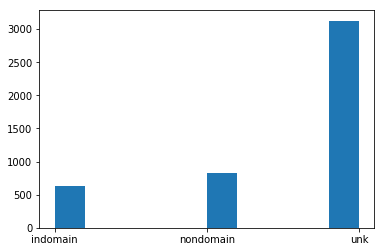

In [413]:
# document count across 4 class labels (unk,nondomain,indomain,eval_incident)

print(raw_data.class_type.value_counts())
plt.hist('class_type',data=raw_data)
plt.show()

In [414]:
# write the formatted data to a new text file for future reference
reset_data=raw_data.reset_index()
reset_data.to_csv('C:\\Users\\User\\Desktop\\isi\\Tigrinya.txt', header=True, index=False, sep='\t', mode='w',encoding='utf-8')

In [415]:
# basic stats to understand document length across 3 class labels
raw_data.groupby('class_type').describe()

length                                                        
             count       mean         std  min   25%   50%     75%     max
class_type                                                                
indomain     626.0  78.095847  129.818952  6.0  16.0  23.0  121.75  1286.0
nondomain    821.0  35.053593   91.601947  6.0  15.0  21.0   24.00   932.0
unk         3126.0  87.422265  250.076025  6.0  13.0  20.0   55.00  4900.0

In [416]:
# Document Term matrix (binary matrix) with max_df =0.995, min_df =0.001

vectorizer = CountVectorizer(encoding='utf-8',stop_words=None,max_df =0.995, min_df =0.001, binary = True,lowercase=False)
doc_word_mat = vectorizer.fit_transform(raw_data.text_data)
doc_word_mat = ss.csr_matrix(doc_word_mat)

In [417]:
doc_word_mat.shape # n_docs x m_words

(4573, 6737)

In [418]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))

In [419]:
# Train the CorEx topic model with 25 topics
topic_model = Corex(n_hidden=25, words=words, max_iter=1500, verbose=False, seed=3192)

In [420]:
topic_model.fit(doc_word_mat, words=words)

In [421]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ከምቲ,እንታይ,እንተ,ሓቂ,ዓለም,እሞ,ይግባእ,የብሉን,ነታ,ታሪኽ
1: እቲ,ናይ,ናብ,ሓበሬታ,ነቲ,እዋን,ምስ,ኣብቲ,እዩ,ኣብዚ
2: ሕጂ,ንሱ,መን,ሓንቲ,ዓቢ,ስለዝኾነ,ግድን,እየ,ጽቡቕ,ገና
3: ተኻኢሉ,ስለ,ንምፍላጥ,ገዛኢ,ኢህወዴግ,ሕዚ,ተገሊፁ,ዓም,ወሲኹ,ምግላፅ
4: ውን,ወይ,ኣይኮነን,ሃገራት,ጥራይ,ነይሩ,ስለዚ,ገለ,ማለት,ከምዘሎ
5: ስርዓት,ህዝቢ,ዝኾነ,ነዚ,ሰብ,ሃገርና,ምኽንያት,ቃልሲ,ከምኡ,ፖለቲካዊ
6: ኤርትራ,ኤርትራውያን,ህግደፍ,ከኣ,ሃገራዊ,ናጽነት,ለውጢ,ግንባር,ትሕቲ,መንእሰያት
7: ድምጺ,መራገፊ,kbps,መጻወቲ,ምሉእ,ምስማዕ,ትሕዝቶ,ይክኣል,ይብል,ኣቶ
8: ኩሉ,ዝብል,ዘለዎ,ኣብነት,ደቂ,ልዑል,ምበር,ተስፋ,ላዕሊ,ተራ
9: ዘለዉ,ብዘይ,ካልእ,እኳ,ካብቶም,ክንዲ,ዘይኮነ,ዓዲ,ስደት,ምስቲ
10: እዚ,እቶም,ግን,ካብቲ,እንተኾነ,በቲ,ቅድሚ,እዮም,ግዜ,ከባቢ
11: ኣብ,ካብ,ልዕሊ,Ethiopia,ዓመት,Eritrea,ሎሚ,ኩነታት,ዓመታት,ሰብኣዊ
12: ናይቲ,ይኹን,እምበር,ዘይብሉ,ነቶም,ሕጊ,ኢልካ,ህይወት,ሓሳብ,ገበን
13: ኢና,ኢሉ,ከምዚ,ንህዝቢ,የለን,ኮይና,ወዲ,ዘለዋ,ደው,እየን
14: ዘሎ,ኣሎ,ክብል,ውሽጢ,ስራሕ,መወዳእታ,ናይዚ,ኣዝዩ,ኣለና,ካልኣይ
15: ላይ,ነው,እና,የኢትዮጵያ,ጋር,ውስጥ,ቀን,አበባ,ወደ,ህዝብ
16: እውን,ህዝብን,ጥራሕ,ገሊፆም,ዘይኮነስ,መሬት,ባዕሉ,ምሕደራ,ማይ,ረብሓ
17: ስደተኛታት,ባሕሪ,ማእከላይ,ሊብያ,ቁጽሪ,ገማግም,ኣስታት,ትካል,ኢጣልያ,ዋሕዚ
18: ኢሎም,ኣለው,ደቡብ,ሓደጋ,ሱዳን,ተባሂሉ,መራሕቲ,ሓገዝ,ኣብታ,ትካላት
19: ከም,ብምባል,በዚ,እዞም,ብዙሕ,ምህላዎም,ምንቅስቓስ,ብናይ,ብተደጋጋሚ,ሓያል
20: ድማ,ሓደ,ዝሓለፈ,ካልኦት,ወርሒ,ክልተ,ሰሙን,ሰለስተ,ዝተኻየደ,ኣዋርሕ
21: ክልል,ሰባት,ዞባ,ኢትዮጵያ,ተቓውሞ,ኦሮምያ,ነበርቲ,ምዕራብ,ት

In [422]:
#CorEx estimates the probability a document belongs to a topic given that document's words.

#The estimated probabilities of topics for each document can be accessed through p_y_given_x.
print(topic_model.p_y_given_x) # n_docs x k_topics

[[  1.00000000e-06   1.00000000e-06   1.00000000e-06 ...,   8.49395904e-04
    7.96715659e-04   4.14287663e-03]
 [  1.00000000e-06   1.00000000e-06   1.00000000e-06 ...,   8.50571668e-04
    7.98696396e-04   4.15492562e-03]
 [  1.00000000e-06   1.00000000e-06   1.00000000e-06 ...,   8.49906065e-04
    7.97328351e-04   4.14144352e-03]
 ..., 
 [  9.99999000e-01   9.99999000e-01   9.99999000e-01 ...,   9.99999000e-01
    9.99999000e-01   9.99999000e-01]
 [  9.99999000e-01   9.99999000e-01   9.99999000e-01 ...,   9.99999000e-01
    9.99999000e-01   9.99999000e-01]
 [  9.99999000e-01   9.99999000e-01   9.99999000e-01 ...,   9.99999000e-01
    9.99999000e-01   9.99999000e-01]]


In [423]:
#softmax binary classification of which documents belong to each topic.
print(topic_model.labels) # n_docs x k_topics

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]


Text(0,0.5,'Total Correlation (nats)')

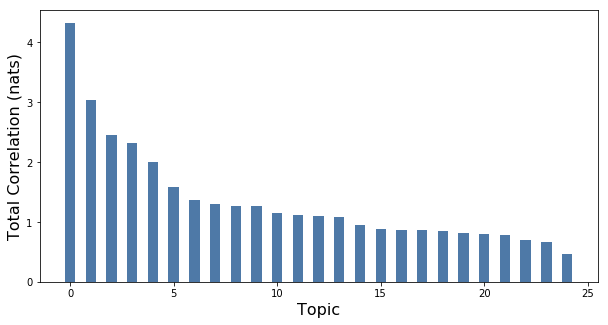

In [424]:

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color = '#4e79a7', width = 0.5)
plt.xlabel('Topic', fontsize = 16)
plt.ylabel('Total Correlation (nats)', fontsize = 16)

In [476]:
# Anchor words
#Tigrinya (script is left-to-right):
#earthquake: ~ምንቅጥቃጥ መሬት   (Romanized: meneqeteqaate mareete)

#drought: ~ነቕጺ            (Romanized: naqhetsi)
#flood: ~ዕልቕልቕ            (Romanized: eleqheleqhe)
#disaster: መዓት; ~መቕዘፍቲ    (Romanized: maaate; maqhezafeti)
 
anchor_words = [["መሬት"],
                ["መዓት"]]


anchored_topic_model = Corex(n_hidden=25,max_iter=1500, seed=3192)   
anchored_topic_model.fit(doc_word_mat, words=words, anchors=anchor_words, anchor_strength=6);

In [464]:
for n in range(len(anchor_words)):
    topic_words,_ = zip(*anchored_topic_model.get_topics(topic=n))
    print('{}: '.format(n) + ','.join(topic_words))

0: መሬት,እቲ,ከም,ድማ,ግን,ኮይኑ,ሓደ,ሰብ,ኢሉ,ዘለዎ
1: ከምቲ,ሕጂ,እንተ,ነታ,ሓንቲ,የብሉን,ዓቢ,ወዲ,መዓት,ዓዲ


In [465]:
#CorEx estimates the probability a document belongs to a topic given that document's words.

print(anchored_topic_model.p_y_given_x) # n_docs x k_topics

[[  4.76272005e-06   1.00000000e-06   8.67954266e-05 ...,   1.00000000e-06
    1.00142421e-03   1.26709157e-05]
 [  4.76389264e-06   1.00000000e-06   8.68176894e-05 ...,   1.00000000e-06
    9.63248350e-04   1.26706228e-05]
 [  4.76389286e-06   1.00000000e-06   8.68110080e-05 ...,   1.00000000e-06
    1.00141812e-03   1.26705210e-05]
 ..., 
 [  9.99999000e-01   9.99999000e-01   9.99999000e-01 ...,   9.99999000e-01
    9.99999000e-01   9.99999000e-01]
 [  9.99999000e-01   9.99999000e-01   9.99999000e-01 ...,   9.99999000e-01
    9.99999000e-01   9.99999000e-01]
 [  9.99999000e-01   9.99999000e-01   9.99999000e-01 ...,   9.99999000e-01
    9.99999000e-01   9.99999000e-01]]


In [428]:
#softmax binary classification of which documents belong to each topic.
topic_classification=anchored_topic_model.labels[:,0:2] # n_docs x k_topics

In [429]:
result=pd.DataFrame(topic_classification,columns=["topic1","topic2"])

In [430]:
raw_data=raw_data.reset_index()
result["doc_id"]=raw_data["doc_id"]
result["true_class_label"]=raw_data["class_type"]

In [431]:
result.loc[(result['topic1']==True) | (result['topic2']==True)  , 'predicted_class_label'] = "indomain"

In [432]:
result.loc[(result['topic1']==False) & (result['topic2']==False)  , 'predicted_class_label'] = "nondomain"

In [433]:
# filter unknown class
print("shape before filtering unknown docs",result.shape )
result = result.loc[result.true_class_label !="unk"]
print("shape after filtering unknown docs",result.shape )

shape before filtering unknown docs (4573, 5)
shape after filtering unknown docs (1447, 5)


In [434]:
result.loc[(result['true_class_label']=="indomain") & (result['predicted_class_label']=="indomain")].shape

(157, 5)

In [437]:
from sklearn.metrics import confusion_matrix
cm=pd.DataFrame(confusion_matrix(result.true_class_label, result.predicted_class_label),columns=["Predicted++","Predicted--"],index=["Actual++","Actual--"])
cm

,Predicted++,Predicted--
Actual++,157,469
Actual--,48,773


In [438]:
precision = cm.loc["Actual++","Predicted++"]/(cm.loc["Actual++","Predicted++"] + cm.loc["Actual--","Predicted++"])
precision

0.76585365853658538

In [439]:
recall =  cm.loc["Actual++","Predicted++"]/(cm.loc["Actual++","Predicted++"] + cm.loc["Actual++","Predicted--"] )
recall

0.25079872204472842

In [440]:
F1_score = 2*(precision * recall)/(precision + recall)
F1_score

0.37785800240673889

In [478]:
# Top 10 docs for topic 1


topic1_docs_id = result.loc[(result.true_class_label=="indomain")&(result.topic1==True),"doc_id"]

topic1_docs_id.shape

topic1_docs =raw_data.loc[raw_data.doc_id.isin(topic1_docs_id),["doc_id","text_data"]]
topic1_docs= topic1_docs.set_index('doc_id')

 
#anchor_words = [["መሬት"],["መዓት"]]

topic1_docs['count'] = topic1_docs['text_data'].apply(lambda x: pd.Series(x.split()).str.contains(r'መሬት').sum())

topic1_docs.sort_values(by=['count'],ascending=False,inplace=True)

topic1_docs.iloc[0:10,:]

,text_data,count
doc_id,,
IL5_NW_020508_20151218_H0040MWHT,መንግስቲ ኢትዮጵያ ፣ ኣብ ኣዲስ ኣበባን ከባቢኣን ዝወጠኖ ናይ መሬት ልም...,5
IL5_WL_020506_20160205_H0040ME5F,ኣብ ክልል ጋምቤላ ኣብዚ ሕዚ እዋን ብዝተልዓለ ግጭትን ዕግርግርን ምኽንያ...,5
IL5_NW_020060_20160825_G0040KICM,ኣትለት ፈይሳ ለሊሳ ንመግለጺ መንግስቲ ብምእማን ከይምለስ ስድራቤቱ ኣጠን...,2
IL5_WL_020506_20161223_H0040MDS6,ኣብ ጃዊን ከባቢኣን ኣብ ልዕሊ ገዛኢ ስርዓት ኢህወደግ ሓያል ተቃውሞ ህዝ...,2
IL5_NW_020508_20160202_H0040MWHU,ኣብ ኢትዮጵያ ፣ ክልል ጋምቤላ ኣብ ዝተኻየደ ቀቢላዊ ግጭት ሰባት ከምዝ...,2
IL5_WL_020506_20160326_H0040ME1K,ኣብ ዞባ ምዕራብ ዝርከቡ ኣመሓደርቲ ብዝፈፀምዎ ግዑዝይ ኣሰራርሓ ፣ ህዝቢ...,2
IL5_SN_000370_20170210_H0T0036X1,ህወሓትን ሕቶ መሬትን ህዝቢ ትግራይ ንቓልሲ ክላዓዓልን ኣንፃር ገዛእቲ ደ...,2
IL5_SN_000370_20160106_G0T000A4D,ሰሜን ኮርያ ፡ ሃይትሮጅን ቦምብ ፈቲና ሎሚ ኣብ ሰዓታት ቅድሚ ቀትሪ ምን...,2
IL5_NW_020079_20160609_G0040IC0X,ምጽራይ ሕሃ ገበናት ኣንጻር ሰብኣውነት ኣብ ኤርትራ ረኺቡ ጀኔቫ ሰ ነ ...,1


In [479]:
# Top 10 docs for topic 2


topic2_docs_id = result.loc[(result.true_class_label=="indomain")&(result.topic2==True),"doc_id"]

topic2_docs_id.shape

topic2_docs =raw_data.loc[raw_data.doc_id.isin(topic2_docs_id),["doc_id","text_data"]]
topic2_docs= topic2_docs.set_index('doc_id')

 
#anchor_words = [["መሬት"],["መዓት"]]

topic2_docs['count'] = topic2_docs['text_data'].apply(lambda x: pd.Series(x.split()).str.contains(r'መዓት').sum())

topic2_docs.sort_values(by=['count'],ascending=False,inplace=True)

topic2_docs.iloc[0:10,:]

,text_data,count
doc_id,,
IL5_SN_000370_20170203_H0T0036QB,መስጊድ ። ታሪኻዊት ከተማ ናቕፋ ። መዓት መዳፍዕን ፣ ተወንጨፍትን ፣ ደ...,1
IL5_NW_020490_20160328_H0040MCA6,ሓለዋ ባሕሪ ሊብያ ፥ ሬሳ ናይ ካብ ኤርትራን ኒጀርን ኢዮም ዝበሎም ዓሰር...,0
IL5_NW_020062_20150611_G0040EZAF,ሓርነትን ጭቆናን ኣማኑኤል ሳህለ መብዛሕትኡ ናይ መውጽእ ሓራ ውድብ ወይ ...,0
IL5_NW_020079_20151124_G0040IC2Q,እዋናዊ ሃለዋት ኤርትራ ዕለት ሕዳር ዓም ይ ሓድሽ ሓበሬታ ንእዋናዊ ሃ...,0
IL5_NW_020079_20160610_G0040IC0W,ኣገዳሲ መግለጺ ውህደት ደሞክራሲያዊት ኤርትራ ኣብ ኢጣልያ ዕለት ኣገዳሲ...,0
IL5_NW_020490_20160523_H0040MC9X,ንሰብኣዊ መሰላት ዝጣበቕ ጉጅለ ግፍዕታት ዳዒሽ ኣብ ሊብያ ሰኒዱ ሓደ ፍሉ...,0
IL5_NW_020079_20160609_G0040IC0X,ምጽራይ ሕሃ ገበናት ኣንጻር ሰብኣውነት ኣብ ኤርትራ ረኺቡ ጀኔቫ ሰ ነ ...,0
IL5_NW_020062_20160908_G0040KJ4B,እዋናዊ ዜናታት – ጀርመን ንቅሉዕ ጥሕሰት ሰብኣዊ መሰላት ምልካዊ ስርዓት...,0
IL5_NW_020062_20150613_G0040EZAB,ስርዓት ህግደፍ ካብ ህዝቢ ኣብ ውሽጢን ወጻእን ዝወርዶ ዘሎ ተጽዕኖ መኣዝ...,0


In [470]:
# Alternative approach -- guided-LDA
# reference links below
#1) https://medium.freecodecamp.org/how-we-changed-unsupervised-lda-to-semi-supervised-guidedlda-e36a95f3a164
#2)https://github.com/vi3k6i5/GuidedLDA

import numpy as np
import guidedlda
model = guidedlda.GuidedLDA(n_topics=25, n_iter=500, random_state=3192, refresh=20)

In [471]:
# Document-Term Matrix-(count matrix)
vectorizer2 = CountVectorizer(encoding='utf-8',stop_words=None,max_df =0.995, min_df =0.001, binary = False,lowercase=False)
doc_word_mat2 = vectorizer2.fit_transform(raw_data.text_data)
doc_word_mat2 = ss.csr_matrix(doc_word_mat2)
doc_word_mat2

<4573x6737 sparse matrix of type '<class 'numpy.int64'>'
	with 141253 stored elements in Compressed Sparse Row format>

In [472]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words2 = list(np.asarray(vectorizer2.get_feature_names()))
word2id = dict((v, idx) for idx, v in enumerate(words2))

In [473]:
# seeding anchor words
seed_topic_list =[["መሬት"],["መዓት"]]
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [474]:
model.fit(doc_word_mat2, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 4573
INFO:guidedlda:vocab_size: 6737
INFO:guidedlda:n_words: 223793
INFO:guidedlda:n_topics: 25
INFO:guidedlda:n_iter: 500
INFO:guidedlda:<0> log likelihood: -2831412
INFO:guidedlda:<20> log likelihood: -1856304
INFO:guidedlda:<40> log likelihood: -1796577
INFO:guidedlda:<60> log likelihood: -1769756
INFO:guidedlda:<80> log likelihood: -1755224
INFO:guidedlda:<100> log likelihood: -1746401
INFO:guidedlda:<120> log likelihood: -1738963
INFO:guidedlda:<140> log likelihood: -1733749
INFO:guidedlda:<160> log likelihood: -1728650
INFO:guidedlda:<180> log likelihood: -1726219
INFO:guidedlda:<200> log likelihood: -1724189
INFO:guidedlda:<220> log likelihood: -1722245
INFO:guidedlda:<240> log likelihood: -1720728
INFO:guidedlda:<260> log likelihood: -1720140
INFO:guidedlda:<280> log likelihood: -1717706
INFO:guidedlda:<300> log likelihood: -1717837
INFO:guidedlda:<320> log likelihood: -1715873
INFO:guidedlda:<340> log likelihood: -1714592
INFO:guidedlda:<360> log li

In [475]:
#[["መሬት"],["መዓት"]]
n_top_words = 20
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(words2)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: the of in to Eritrea and Ethiopia The is on Ethiopian by Eritrean has for from Tigray via are that
Topic 1: ናይ እቲ ድማ ከም ወይ ነቲ ግን ሰብ ስለ ማለት ህዝቢ ነዚ እንተ ዝኾነ ጥራይ ምስ ኣብቲ ኩሉ ሓደ ናይቲ
Topic 2: ከም ኣብ እቲ ሓበሬታ ናይ ከተማ ድማ ስርዓት ካብ ህዝቢ ዘሎ ተኻኢሉ ተፈሊጡ ንምፍላጥ ከባቢ ዝርከቡ ናብ ዓም ተገሊፁ ነቲ
Topic 3: ኣብ ህዝቢ ስርዓት ህግደፍ ካብ ሃገር ቃልሲ ዘሎ ድማ ናይ ግን እቲ ህዝባዊ እዚ ዓመት ህዝብና ዓመታት ሓደ ስለ ሎሚ
Topic 4: ኣብ ኢትዮጵያ ካብ እቲ ሓገዝ ማይ ብሰንኪ ከተማ ሓደጋ ጥዕና ድርቂ ሚልዮን ደርቂ ዘሎ እውን መቐለ ሕክምና ሰብ እዋን ትካል
Topic 5: ኣብ ናይ ካብ እቲ ናብ ስርዓት ኤርትራ ዘሎ ኤርትራውያን ሓበሬታ ነቲ ምልካዊ ኢሳይያስ እቶም ናይቲ ዑቕባ እዩ ምንጭታት ምዃኑ ከምዘሎ
Topic 6: ኣብ እቲ ደቂ ኣንስትዮ ናይ ገለ ከም ወይ እቶም ውን ፊልም ቋንቋ ግዜ ትግርኛ ቤት ሓንቲ ውሽጢ መጽሓፍ ምልክት ሓበሬታ
Topic 7: ኣብ ኤርትራ ሃገራት ሰብኣዊ ሕቡራት መሰላት ኤርትራውያን ኢትዮጵያ ህግደፍ መንግስቲ ውድብ ካብ ኮምሽን ምስ ኢሳያስ መንግስታት ኤርትራን ጸብጻብ ኣንጻር ናብ
Topic 8: ትግራይ ኣብ ዞባ ካብ ህዝቢ ወረዳ ክልል ጣብያ ኣምሓራ ናብ ሕቶ ዴምህት ፓርቲ ኣቶ ወልቃይት ህወሓት ዝነበረ እዚ መንነት ኢትዮጵያ
Topic 9: ኣብ ኤርትራ ምስ ካብ ውን ድማ ናጽነት ወዲ ዝነበረ ሓደ ኢሳይያስ ድሕሪ ከምቲ ሓርነት ተጋደልቲ ተጋዳላይ በቲ ኔሩ ዓዲ ኣብቲ
Topic 10: እዩ ኣብ እቲ እዚ እዮም ምስ ካብ ኣሎ ከኣ ከም ግዜ ናብ እያ ሓደ ዘሎ እውን ኣብቲ ኣብዚ ብዙሕ ኸኣ
Topic 11: ኣብ ውን